In [1]:
# iEEG imports
from ieeg.auth import Session

# Scientific computing imports
import numpy as np
import scipy as sc
import pandas as pd
import json

from scipy.linalg import hankel
from tqdm import tqdm
from sklearn.metrics import recall_score, f1_score
from sklearn.metrics import precision_score
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import cohen_kappa_score

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from statsmodels.stats.multitest import multipletests
# Imports for analysis
from seizure_detection_pipeline import prepare_segment, TRAIN_WIN, PRED_WIN

# OS imports
import os
from os.path import join as ospj
from os.path import exists as ospe
from utils import *
import sys
sys.path.append('/users/wojemann/iEEG_processing')
plt.rcParams['image.cmap'] = 'magma'

2024-10-15 18:54:51.759159: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-15 18:54:52.841864: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['lines.linewidth'] = 2

plt.rcParams['xtick.major.size'] = 5  # Change to your desired major tick size
plt.rcParams['ytick.major.size'] = 5  # Change to your desired major tick size
plt.rcParams['xtick.minor.size'] = 3   # Change to your desired minor tick size
plt.rcParams['ytick.minor.size'] = 3   # Change to your desired minor tick size

plt.rcParams['xtick.major.width'] = 2  # Change to your desired major tick width
plt.rcParams['ytick.major.width'] = 2  # Change to your desired major tick width
plt.rcParams['xtick.minor.width'] = 1  # Change to your desired minor tick width
plt.rcParams['ytick.minor.width'] = 1  # Change to your desired minor tick width

In [3]:
def wideform_preds(element,all_labels):
    return [label in element for label in all_labels]

def shortform_preds(element,all_labels):
    a = np.array(all_labels)[element]
    return a
def apply_dice_score(row):
    all_chs = row.all_chs
    for col in ['ueo_consensus','ueo_any','sec_consensus','sec_any']:
        row[col+'_chs'] = shortform_preds(row[col],all_chs)
        for pred in ['strict','loose']:
            ch_preds = row[f'{col[:3]}_chs_{pred}']
            if (len(ch_preds) + len(row[col+'_chs'])) == 0:
                row[f'{col}_{pred}_dice'] = 0
            else:
                row[f'{col}_{pred}_dice'] = dice_score(row[col+'_chs'],ch_preds)
    return row

def apply_kappa_score(row):
    all_chs = row.all_chs
    for col in ['ueo_chs_strict','ueo_chs_loose','sec_chs_strict','sec_chs_loose']:
        # need to turn model predictions into the wideform
        row[col+'_bool'] = wideform_preds(row[col],all_chs)
        for annot in ['consensus','any']:
            ch_preds = row[f'{col[:3]}_{annot}']
            # if (sum(ch_preds) + sum(row[col+'_bool'])) == 0:
            #     row[f'{col}_{annot}_kappa'] = 0
            # else:
            row[f'{col}_{annot}_kappa'] = cohen_kappa_score(row[col+'_bool'],ch_preds)
    return row

def apply_specificity(row):
    all_chs = row.all_chs
    for col in ['ueo_chs_strict','ueo_chs_loose','sec_chs_strict','sec_chs_loose']:
        # need to turn model predictions into the wideform
        row[col+'_bool'] = np.atleast_1d(wideform_preds(row[col],all_chs))
        for annot in ['consensus','any']:
            ch_preds = row[f'{col[:3]}_{annot}']
            # if (sum(ch_preds) + sum(row[col+'_bool'])) == 0:
            #     row[f'{col}_{annot}_kappa'] = 0
            # else:
            row[f'{col}_{annot}_spec'] = recall_score(row[col+'_bool']==False,ch_preds==False)
    return row

## Config

In [4]:
usr,passpath,datapath,prodatapath,metapath,figpath,patient_table,rid_hup,pt_list = load_config(ospj('/mnt/leif/littlab/users/wojemann/stim-seizures/code','config.json'))

In [5]:
patient_table

,ptID,ieeg_ids,lf_stim,hf_stim,typical,mtle,focality,laterality,interictal_training
13,HUP224,"[HUP224_phaseII, HUP224_CCEP]",1,0,0.0,1.0,1.0,2.0,"[HUP224_phaseII, 5915]"
14,HUP225,"[HUP225_phaseII, HUP225_CCEP]",1,0,1.0,0.0,0.0,1.0,"[HUP225_phaseII, 71207]"
15,HUP229,"[HUP229_phaseII, HUP229_CCEP]",1,0,1.0,1.0,0.0,0.0,"[HUP229_phaseII, 149146]"
16,HUP230,"[HUP230_phaseII, HUP230_CCEP]",1,0,1.0,1.0,0.0,0.0,"[HUP230_phaseII, 25350]"
17,HUP235,"[HUP235_phaseII, HUP235_CCEP]",1,1,1.0,1.0,0.0,0.0,"[HUP235_phaseII, 307651]"
18,HUP238,"[HUP238_phaseII, HUP238_CCEP]",1,0,1.0,1.0,0.0,0.0,"[HUP238_phaseII, 100011]"
19,HUP246,"[HUP246_phaseII, HUP246_CCEP]",1,0,1.0,1.0,0.0,0.0,"[HUP246_phaseII, 100000]"
20,HUP247,"[HUP247_phaseII, HUP247_CCEP]",1,0,1.0,0.0,0.0,1.0,"[HUP247_phaseII, 17590]"
21,HUP249,"[HUP249_phaseII, HUP249_CCEP]",1,0,0.0,0.0,1.0,2.0,"[HUP249_phaseII, 24112]"
22,HUP250,"[HUP250_phaseII, HUP250_CCEP]",1,0,1.0,0.0,2.0,3.0,"[HUP250_phaseII, 24841]"


## Formatting Model Predictions

### Channel level

In [10]:
# Loading in human annotations with consensus annotation already created
annotations_df = pd.read_pickle(ospj(prodatapath,"stim_seizure_information_consensus.pkl"))
annotations_df.columns = ['Patient' if c == 'patient' else c for c in annotations_df.columns]

# Loading in predicted channels for all models from generate_model_annotations.py
predicted_channels = pd.read_pickle(ospj(prodatapath,"pretrain_predicted_channels_nor.pkl"))
predicted_channels = predicted_channels[predicted_channels.to_annotate == 1]

# Sorting
predicted_channels.sort_values('approximate_onset',inplace=True)
# predicted_channels = predicted_channels[predicted_channels.stim == 0]
annotations_df.sort_values('approximate_onset',inplace=True)

# Creating a merged table with human and machine annotations based on approximate seizure onset time
pred_channels_wannots = pd.merge_asof(predicted_channels,
                                    annotations_df[['approximate_onset','Patient','all_chs','ueo_consensus','ueo_any','sec_consensus','sec_any']],
                                    on='approximate_onset',by='Patient',
                                    tolerance = 240,
                                    direction='nearest')
pred_channels_wannots.dropna(axis=0,subset='ueo_consensus',inplace=True)
pred_channels_wannots.sort_values(['Patient','iEEG_ID','approximate_onset'],inplace=True)
pred_channels_wdice = pred_channels_wannots.apply(apply_dice_score,axis=1)
# pred_channels_wkappa = pred_channels_wannots.apply(apply_kappa_score,axis=1)
# # pred_channels_wspec = pred_channels_wannots.apply(apply_specificity,axis=1)

In [11]:
# # pred_channels_wspec.to_pickle(ospj(prodatapath,f"pretrain_predicted_channels_wspec.pkl"))
pred_channels_wdice.to_pickle(ospj(prodatapath,f"pretrain_predicted_channels_wdice_nor.pkl"))
# pred_channels_wkappa.to_pickle(ospj(prodatapath,f"pretrain_predicted_channels_wkappa_nor.pkl"))

## Channel Agreement Optimization

### Calculating clinician consensus


In [14]:
consensus_annots = pd.read_pickle(ospj(prodatapath,'stim_seizure_information_consensus.pkl'))
# spread_consensus_annots = consensus_annots.copy()
# for i_r, row in consensus_annots.iterrows():
#     annot_sets = row.ueo
#     die = 0
#     for annot in annot_sets:
#         die += f1_score(annot,row.ueo_consensus)
#     consensus_annots.loc[i_r,'f1'] = die/len(annot_sets)
# for i_r, row in spread_consensus_annots.iterrows():
#     annot_sets = row.sec
#     die = 0
#     for annot in annot_sets:
#         die += f1_score(annot,row.sec_consensus)
#     spread_consensus_annots.loc[i_r,'f1'] = die/len(annot_sets)

In [15]:
consensus_annots = consensus_annots[consensus_annots.stim == 0]
spread_consensus_annots = consensus_annots.copy()
note_type = 'ueo'
for i_r, row in consensus_annots.iterrows():
    scores = 0
    annots = row[note_type]
    for i_annot in range(len(annots)):
        for j_annot in range(i_annot+1,len(annots)):
            scores += f1_score(annots[i_annot],annots[j_annot])
    consensus_annots.loc[i_r,'f1'] = scores/(len(annots)*(len(annots)-1)/2)
consensus_annots["model"] = ["Clin."]*len(consensus_annots)
consensus_annots["dice"] = consensus_annots["f1"]


note_type = 'sec'
for i_r, row in spread_consensus_annots.iterrows():
    scores = 0
    annots = row[note_type]
    for i_annot in range(len(annots)):
        for j_annot in range(i_annot+1,len(annots)):
            scores += f1_score(annots[i_annot],annots[j_annot])
    spread_consensus_annots.loc[i_r,'f1'] = scores/(len(annots)*(len(annots)-1)/2)


### Data Prep

In [16]:
anntype='consensus'
mdl_anntype = 'strict'
montage = 'bipolar'
mdl_preds = pd.read_pickle(ospj(prodatapath,f"pretrain_predicted_channels_wdice_nor.pkl"))

In [17]:
mdl_preds = mdl_preds[mdl_preds.stim == 0]

In [18]:
mdl_preds_sorted = mdl_preds.sort_values(['Patient','approximate_onset','threshold','model'])

In [19]:
melt_cols = [f'ueo_{anntype}_{mdl_anntype}_dice',f'sec_{anntype}_{mdl_anntype}_dice']
keep_cols = [c for c in mdl_preds_sorted.columns if c not in melt_cols]
mdl_preds_long = mdl_preds_sorted.melt(id_vars=keep_cols,var_name='annot',value_name='dice')
mdl_preds_long.Patient.unique()

array(['HUP224', 'HUP225', 'HUP229', 'HUP230', 'HUP235', 'HUP238',
       'HUP246', 'HUP247', 'HUP249', 'HUP250', 'HUP253', 'HUP257',
       'HUP263', 'HUP266'], dtype=object)

In [20]:
tune_preds_long = mdl_preds_long[mdl_preds_long.annot == 'ueo_consensus_strict_dice']
val_preds_long = mdl_preds_long[mdl_preds_long.annot == 'sec_consensus_strict_dice']

### Threshold sweeping

In [21]:
# fig,axs = plt.subplots(1,2)
# sns.lineplot(data=mdl_preds_long[mdl_preds_long.annot == f'ueo_{anntype}_{mdl_anntype}_dice'],x='threshold',y='dice',hue='model',ax=axs[0])
# axs[0].set_ylim((-.1,.7))
# axs[0].set_title('Onset Annots')
# sns.lineplot(data=mdl_preds_long[mdl_preds_long.annot == f'sec_{anntype}_{mdl_anntype}_dice'],x='threshold',y='dice',hue='model',ax=axs[1],legend=False)
# axs[1].set_ylim((-.1,.7))
# axs[1].set_yticks([])
# axs[1].set_ylabel('')
# axs[1].set_title('Spread Annots')
# fig.suptitle(f'Model Annotator Agreement - {anntype}')
# fig.savefig(ospj(figpath,f'ueo_ch_dice_{anntype}-{mdl_anntype}.pdf'),transparent=True)

In [22]:
# fig,ax = plt.subplots()
# ax = sns.lineplot(data=mdl_preds_long[(mdl_preds_long.annot == f'ueo_{anntype}_{mdl_anntype}_dice') & (mdl_preds_long.model == 'WVNT')],x='threshold',y='dice',hue='Patient',errorbar=None,legend=True)
# fig.savefig(ospj(figpath,f'pt_WVNT_ueo_ch_dice_{anntype}-{mdl_anntype}.pdf'),transparent=True)

In [23]:
# ax = sns.lineplot(data=mdl_preds_long[(mdl_preds_long.annot == f'ueo_{anntype}_{mdl_anntype}_dice') & (mdl_preds_long.model == 'LSTM')],x='threshold',y='dice',hue='Patient',errorbar=None,)

### Tuning at the seizure level

#### Tuning and testing on onset

In [24]:
optimal_threshold_preds = tune_preds_long.loc[tune_preds_long.groupby(['Patient', 'approximate_onset','model'])['dice'].idxmax()][["model","dice","Patient","stim","approximate_onset",'threshold']]

In [25]:
consensus_annots["model"] = ["Clin."]*len(consensus_annots)
consensus_annots["dice"] = consensus_annots["f1"]
all_plot_agreements = pd.concat([optimal_threshold_preds,consensus_annots[["model","dice"]]])

In [26]:
for mdl in optimal_threshold_preds.model.unique():
    print(mdl)
    print(sc.stats.mannwhitneyu(consensus_annots.f1,optimal_threshold_preds[optimal_threshold_preds.model == mdl].dice))

AbsSlp
MannwhitneyuResult(statistic=1046.5, pvalue=0.0007415581195374715)
LSTM
MannwhitneyuResult(statistic=742.5, pvalue=0.8311665708781424)
NRG
MannwhitneyuResult(statistic=937.5, pvalue=0.02504207134653914)
WVNT
MannwhitneyuResult(statistic=850.5, pvalue=0.18138610053705362)


In [21]:
print(sc.stats.mannwhitneyu(optimal_threshold_preds[optimal_threshold_preds.model == 'LSTM'].dice,optimal_threshold_preds[optimal_threshold_preds.model == 'WVNT'].dice))

MannwhitneyuResult(statistic=795.0, pvalue=0.23237698723370537)


Text(0.5, 1.0, 'Onset Tuned Onset Detection')

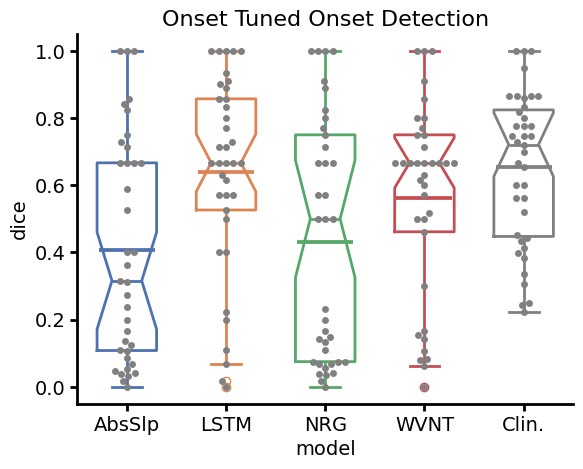

In [22]:
colors = sns.color_palette("deep", 4)
bx = sns.boxplot(all_plot_agreements,x='model',y='dice',palette=np.vstack([np.array(colors),[.5,.5,.5]]),
                 order=['AbsSlp','LSTM','NRG','WVNT','Clin.'],width=.6,notch=True,fill=False)
sns.swarmplot(all_plot_agreements,x='model',y='dice',color='gray')
sns.pointplot(all_plot_agreements,x='model',y='dice',palette=np.vstack([np.array(colors),[.5,.5,.5]]),
              order = ['AbsSlp','LSTM','NRG','WVNT','Clin.'],marker='_',markersize=40,errorbar=None)
sns.despine()
plt.title("Onset Tuned Onset Detection")

#### Testing on spread

In [27]:
val_tuned_thresholds = val_preds_long[['Patient','approximate_onset','model','threshold','dice']].merge(optimal_threshold_preds[['Patient','approximate_onset','model','threshold']],on=['Patient','approximate_onset','model','threshold'],how='inner')

In [28]:
spread_consensus_annots["model"] = ["Clin."]*len(spread_consensus_annots)
spread_consensus_annots["dice"] = spread_consensus_annots["f1"]
spread_plot_agreements = pd.concat([val_tuned_thresholds,spread_consensus_annots[["model","dice"]]])

In [29]:
all_ps = []
for mdl in val_tuned_thresholds.model.unique():
    print(mdl)
    p = sc.stats.mannwhitneyu(spread_consensus_annots.f1,val_tuned_thresholds[val_tuned_thresholds.model == mdl].dice)
    print(p)
    all_ps.append(p[1])
multipletests(all_ps)

NRG
MannwhitneyuResult(statistic=1020.0, pvalue=0.001954386053293533)
AbsSlp
MannwhitneyuResult(statistic=1069.0, pvalue=0.0003106480766403098)
LSTM
MannwhitneyuResult(statistic=927.0, pvalue=0.0331210467592858)
WVNT
MannwhitneyuResult(statistic=1066.0, pvalue=0.0003499942476748425)


(array([ True,  True,  True,  True]),
 array([0.00390495, 0.00124201, 0.03312105, 0.00124201]),
 0.012741455098566168,
 0.0125)

Text(0.5, 1.0, 'Seizure Annotation Generalization to Spread')

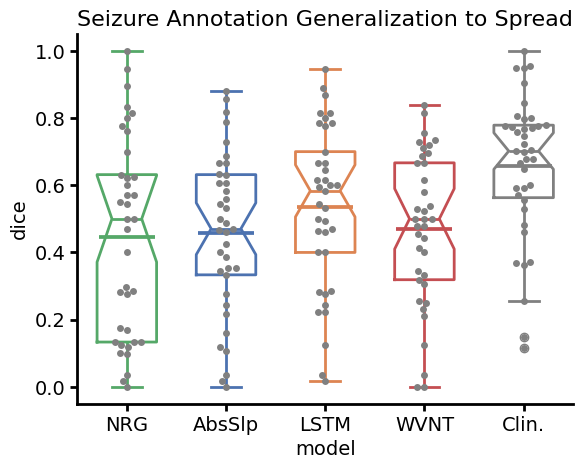

In [30]:
colors = sns.color_palette("deep", 4)
sns.swarmplot(spread_plot_agreements,x='model',y='dice',color='gray')
sns.pointplot(spread_plot_agreements,x='model',y='dice',palette=np.vstack([np.array(colors),[.5,.5,.5]]),
              order = ['AbsSlp','LSTM','NRG','WVNT','Clin.'],marker='_',markersize=40,errorbar=None)
sns.boxplot(spread_plot_agreements,x='model',y='dice',palette=np.vstack([np.array(colors),[.5,.5,.5]]),
                 order=['AbsSlp','LSTM','NRG','WVNT','Clin.'],width=.6,notch=True,fill=False)
sns.despine()
plt.title("Seizure Annotation Generalization to Spread")

In [31]:
print(sc.stats.mannwhitneyu(val_tuned_thresholds[val_tuned_thresholds.model == 'LSTM'].dice,val_tuned_thresholds[val_tuned_thresholds.model == 'WVNT'].dice))

MannwhitneyuResult(statistic=788.5, pvalue=0.2630403708734165)


### Tuning at the patient level

In [32]:
# Group by 'Patient', 'model', and 'threshold' to calculate the average dice score for each threshold
avg_dice_per_threshold = tune_preds_long.groupby(['Patient', 'model', 'threshold','annot'])['dice'].mean().reset_index()

# Now, for each 'Patient' and 'model', find the threshold that maximizes the average dice score
threshold_list = avg_dice_per_threshold.loc[avg_dice_per_threshold.groupby(['Patient', 'model','annot'])['dice'].idxmax()]

# The result will contain the patient, model, threshold, and the average dice score
threshold_list = threshold_list[['Patient', 'model', 'threshold', 'dice']].reset_index(drop=True)
print(threshold_list)

   Patient   model  threshold      dice
0   HUP224  AbsSlp       0.09  0.476190
1   HUP224    LSTM       0.14  0.422222
2   HUP224     NRG       0.01  0.335664
3   HUP224    WVNT       0.26  0.348485
4   HUP225  AbsSlp       0.49  0.095238
5   HUP225    LSTM       0.41  0.166667
6   HUP225     NRG       0.09  0.060606
7   HUP225    WVNT       0.40  0.055556
8   HUP229  AbsSlp       0.07  0.307692
9   HUP229    LSTM       0.06  0.533333
10  HUP229     NRG       0.00  0.133333
11  HUP229    WVNT       0.48  0.461538
12  HUP230  AbsSlp       0.11  0.095602
13  HUP230    LSTM       0.07  0.213014
14  HUP230     NRG       0.10  0.166667
15  HUP230    WVNT       0.41  0.357143
16  HUP235  AbsSlp       0.11  0.374879
17  HUP235    LSTM       0.15  0.688889
18  HUP235     NRG       0.04  0.777778
19  HUP235    WVNT       0.35  0.722222
20  HUP238  AbsSlp       0.05  0.338647
21  HUP238    LSTM       0.08  0.605556
22  HUP238     NRG       0.01  0.550000
23  HUP238    WVNT       0.26  0.521368


In [33]:
val_tuned_thresholds = val_preds_long[['Patient','model','threshold','dice']].merge(threshold_list[['Patient','model','threshold']],on=['Patient','model','threshold'],how='inner')
tuned_thresholds = tune_preds_long[['Patient','model','threshold','dice']].merge(threshold_list[['Patient','model','threshold']],on=['Patient','model','threshold'],how='inner')

#### Onset

In [34]:
all_plot_agreements = pd.concat([tuned_thresholds,consensus_annots[["model","dice"]]])

In [35]:
for mdl in tuned_thresholds.model.unique():
    print(mdl)
    print(sc.stats.mannwhitneyu(consensus_annots.f1,tuned_thresholds[tuned_thresholds.model == mdl].dice))

NRG
MannwhitneyuResult(statistic=1062.5, pvalue=0.00039212953068439114)
AbsSlp
MannwhitneyuResult(statistic=1195.5, pvalue=8.478216258811117e-07)
LSTM
MannwhitneyuResult(statistic=955.0, pvalue=0.01534873965562712)
WVNT
MannwhitneyuResult(statistic=1006.0, pvalue=0.003137439776944744)


Text(0.5, 1.0, 'Patient-level Optimal Onset Threshold')

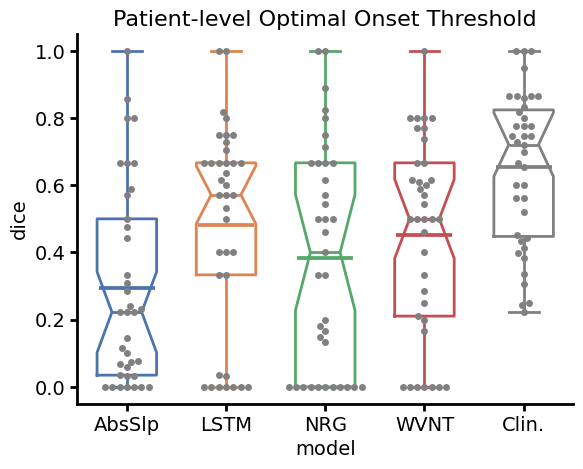

In [36]:
colors = sns.color_palette("deep", 4)
bx = sns.boxplot(all_plot_agreements,x='model',y='dice',palette=np.vstack([np.array(colors),[.5,.5,.5]]),
                 order=['AbsSlp','LSTM','NRG','WVNT','Clin.'],width=.6,notch=True,fill=False)
sns.swarmplot(all_plot_agreements,x='model',y='dice',color='gray')
sns.pointplot(all_plot_agreements,x='model',y='dice',palette=np.vstack([np.array(colors),[.5,.5,.5]]),
              order = ['AbsSlp','LSTM','NRG','WVNT','Clin.'],marker='_',markersize=40,errorbar=None)
sns.despine()
plt.title("Patient-level Optimal Onset Threshold")

In [37]:
print(sc.stats.mannwhitneyu(tuned_thresholds[tuned_thresholds.model == 'LSTM'].dice,tuned_thresholds[tuned_thresholds.model == 'WVNT'].dice))

MannwhitneyuResult(statistic=741.5, pvalue=0.5394205449690004)


#### Spread

In [38]:
all_plot_agreements = pd.concat([val_tuned_thresholds,spread_consensus_annots[["model","dice"]]])

In [39]:
for mdl in val_tuned_thresholds.model.unique():
    print(mdl)
    print(sc.stats.mannwhitneyu(spread_consensus_annots.f1,val_tuned_thresholds[val_tuned_thresholds.model == mdl].dice))

NRG
MannwhitneyuResult(statistic=980.5, pvalue=0.007196615000495002)
AbsSlp
MannwhitneyuResult(statistic=1144.0, pvalue=1.1556309647781356e-05)
LSTM
MannwhitneyuResult(statistic=954.5, pvalue=0.015649503561658874)
WVNT
MannwhitneyuResult(statistic=1034.5, pvalue=0.0011625697367107178)


Text(0.5, 1.0, 'Patient-level Optimal Onset Thresholds Detecting Spread')

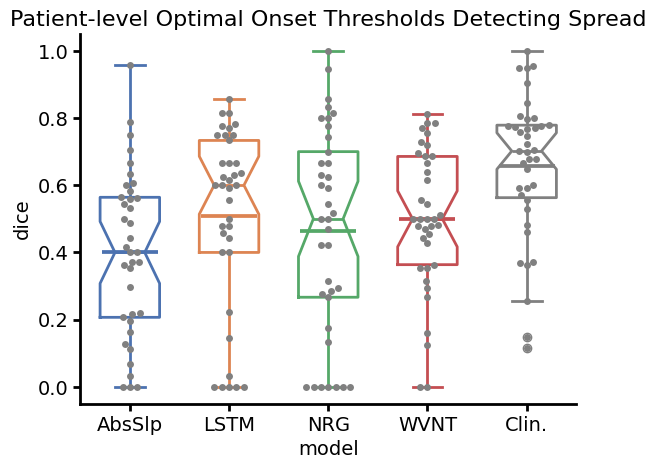

In [40]:
colors = sns.color_palette("deep", 4)
bx = sns.boxplot(all_plot_agreements,x='model',y='dice',palette=np.vstack([np.array(colors),[.5,.5,.5]]),
                 order=['AbsSlp','LSTM','NRG','WVNT','Clin.'],width=.6,notch=True,fill=False)
sns.swarmplot(all_plot_agreements,x='model',y='dice',color='gray')
sns.pointplot(all_plot_agreements,x='model',y='dice',palette=np.vstack([np.array(colors),[.5,.5,.5]]),
              order = ['AbsSlp','LSTM','NRG','WVNT','Clin.'],marker='_',markersize=40,errorbar=None)
sns.despine()
plt.title("Patient-level Optimal Onset Thresholds Detecting Spread")

In [41]:
print(sc.stats.mannwhitneyu(val_tuned_thresholds[val_tuned_thresholds.model == 'LSTM'].dice,val_tuned_thresholds[val_tuned_thresholds.model == 'WVNT'].dice))

MannwhitneyuResult(statistic=746.0, pvalue=0.5092775784006729)


## KDE Model Predictions

In [61]:
# Loading in human annotations with consensus annotation already created
annotations_df = pd.read_pickle(ospj(prodatapath,"stim_seizure_information_consensus.pkl"))
annotations_df.columns = ['Patient' if c == 'patient' else c for c in annotations_df.columns]

# Loading in predicted channels for all models from generate_model_annotations.py
# predicted_channels = pd.read_pickle(ospj(prodatapath,"kdeknee_predicted_channels_nor.pkl"))
predicted_channels = pd.read_pickle(ospj(prodatapath,"gamma_predicted_channels_nor.pkl"))
predicted_channels = predicted_channels[predicted_channels.to_annotate == 1]

# Sorting
predicted_channels.sort_values('approximate_onset',inplace=True)
predicted_channels = predicted_channels[(predicted_channels.stim == 0) & predicted_channels.Patient.apply(lambda x: 'HUP' in x)]
annotations_df.sort_values('approximate_onset',inplace=True)

# Creating a merged table with human and machine annotations based on approximate seizure onset time
pred_channels_wannots = pd.merge_asof(predicted_channels,
                                    annotations_df[['approximate_onset','Patient','all_chs','ueo_consensus','ueo_any','sec_consensus','sec_any']],
                                    on='approximate_onset',by='Patient',
                                    tolerance = 240,
                                    direction='nearest')
pred_channels_wannots.dropna(axis=0,subset='ueo_consensus',inplace=True)
pred_channels_wannots.sort_values(['Patient','iEEG_ID','approximate_onset'],inplace=True)
pred_channels_wdice = pred_channels_wannots.apply(apply_dice_score,axis=1)
pred_channels_wkappa = pred_channels_wannots.apply(apply_kappa_score,axis=1)

In [57]:
# pred_channels_wdice = pred_channels_wdice[pred_channels_wdice.ueo_consensus_strict_dice > 0]

In [62]:
pred_channels_wdice

,Patient,iEEG_ID,model,stim,approximate_onset,ueo_time_consensus,threshold,ueo_chs_strict,ueo_chs_loose,sec_chs_strict,...,ueo_consensus_loose_dice,ueo_any_chs,ueo_any_strict_dice,ueo_any_loose_dice,sec_consensus_chs,sec_consensus_strict_dice,sec_consensus_loose_dice,sec_any_chs,sec_any_strict_dice,sec_any_loose_dice
76,HUP224,HUP224_phaseII,WVNT,0.0,339143.6435,339143.6435,0.400315,[],[],"[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...",...,0.000000,"[RB01, RB02, RB03, RB04, RC01, RC02, RC03]",0.000000,0.000000,"[LB01, LB02, LB03, LB04, LC01, LC02, RB01, RB0...",0.354839,0.311688,"[LB01, LB02, LB03, LB04, LC01, LC02, RB01, RB0...",0.424242,0.395062
77,HUP224,HUP224_phaseII,NRG,0.0,339143.6435,339143.6435,1.289849,"[RA01, RB03]","[RA01, RA02, RB03, RB04]","[LA01, LA03, LA04, LA05, LB01, LB02, LB03, LB0...",...,0.200000,"[RB01, RB02, RB03, RB04, RC01, RC02, RC03]",0.222222,0.363636,"[LB01, LB02, LB03, LB04, LC01, LC02, RB01, RB0...",0.606061,0.523810,"[LB01, LB02, LB03, LB04, LC01, LC02, RB01, RB0...",0.594595,0.565217
78,HUP224,HUP224_phaseII,AbsSlp,0.0,339143.6435,339143.6435,0.264737,"[RA01, RB02, RB03, RC01]","[RA01, RA02, RB02, RB03, RB04, RC01, RC02]","[LA01, LA02, LA03, LA04, LA05, LA06, LB01, LB0...",...,0.615385,"[RB01, RB02, RB03, RB04, RC01, RC02, RC03]",0.545455,0.714286,"[LB01, LB02, LB03, LB04, LC01, LC02, RB01, RB0...",0.512821,0.478261,"[LB01, LB02, LB03, LB04, LC01, LC02, RB01, RB0...",0.511628,0.520000
79,HUP224,HUP224_phaseII,LSTM,0.0,339143.6435,339143.6435,2.176325,"[LB01, LB02, LB03, LB05, LC01, RA01, RA05, RB0...","[LB01, LB02, LB03, LB04, LB05, LB06, LC01, LC0...","[LA01, LA02, LA03, LA04, LA05, LA06, LB01, LB0...",...,0.461538,"[RB01, RB02, RB03, RB04, RC01, RC02, RC03]",0.600000,0.518519,"[LB01, LB02, LB03, LB04, LC01, LC02, RB01, RB0...",0.500000,0.444444,"[LB01, LB02, LB03, LB04, LC01, LC02, RB01, RB0...",0.541667,0.551724
128,HUP224,HUP224_phaseII,LSTM,0.0,491467.8046,491467.8046,2.212052,"[LA01, LB01, LB02, LB03, LB05, LC01, LC03, RA0...","[LA01, LA02, LB01, LB02, LB03, LB04, LB05, LB0...","[LA01, LA02, LA03, LA04, LA05, LA06, LB01, LB0...",...,0.375000,"[RB01, RB02, RB03, RB04, RC01, RC02, RC03]",0.500000,0.424242,"[LB01, LB02, LB03, LB04, LC01, LC02, RB01, RB0...",0.448980,0.406780,"[LB01, LB02, LB03, LB04, LC01, LC02, RB01, RB0...",0.528302,0.507937
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,HUP266,HUP266_phaseII,LSTM,0.0,301581.3500,301581.3500,5.459694,[],[],[],...,0.000000,"[R2A02, R2A03, R2A04, R2A05, R2A06, RU03, RU04...",0.000000,0.000000,"[R2A02, R2A03, R2A04, R2A05, RPC01, RU03, RU04...",0.000000,0.000000,"[R2A01, R2A02, R2A03, R2A04, R2A05, R2A06, RPC...",0.000000,0.000000
104,HUP266,HUP266_phaseII,LSTM,0.0,418859.4191,418859.4191,1.744026,"[R1PO01, R1PO02, R1PO03, R1PO04, RA02, RB01, R...","[R1PO01, R1PO02, R1PO03, R1PO04, R1PO05, RA02,...","[R1PO01, R1PO02, R1PO03, R1PO04, RA02, RA03, R...",...,0.133333,"[R1PO01, R1PO02, RB02, RB03, RC01, RC02]",0.533333,0.526316,"[R1PO01, R1PO02, RA02, RB01, RB02, RB03, RC01,...",0.736842,0.695652,"[R1PO01, R1PO02, RA01, RA02, RB01, RB02, RB03,...",0.700000,0.666667
105,HUP266,HUP266_phaseII,AbsSlp,0.0,418859.4191,418859.4191,0.160123,"[R1PO01, R1PO02, R1PO03, R1PO04, RC03]","[R1PO01, R1PO02, R1PO03, R1PO04, R1PO05, RC03,...","[R1PO01, R1PO02, R1PO03, R1PO04, R1PO05, RA03,...",...,0.000000,"[R1PO01, R1PO02, RB02, RB03, RC01, RC02]",0.363636,0.307692,"[R1PO01, R1PO02, RA02, RB01, RB02, RB03, RC01,...",0.600000,0.583333,"[R1PO01, R1PO02, RA01, RA02, RB01, RB02, RB03,...",0.571429,0.560000
106,HUP266,HUP266_phaseII,WVNT,0.0,418859.4191,418859.4191,0.496195,"[R1PO01, R1PO02, R1PO03, R1PO04, R1PO05, RB01,...","[R1PO01, R1PO02, R1PO03, R1PO04, R1PO05, R1PO0...","[R1PO01, R1PO02, R1PO03, R1PO04, R1PO05, RA03,...",...,0.142857,"[R1PO01, R1PO02, RB02, RB03, RC01, RC02]",0.533333,0.555556,"[R1PO01, R1PO02, RA02, RB01, RB02, RB03, RC01,...",0.631579,0.608696,"[R1PO01, R1PO02, RA01, RA02, RB01, RB02, RB03,...",0.

Text(0.5, 1.0, 'KDE Unsupervised Onset Annotation')

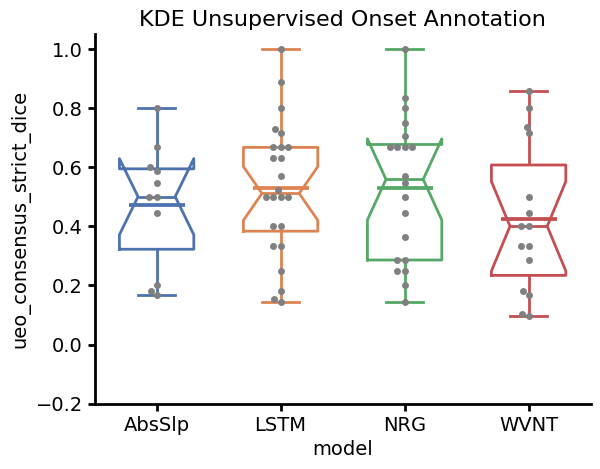

In [59]:
bx = sns.boxplot(pred_channels_wdice,x='model',y='ueo_consensus_strict_dice',palette='deep',order=['AbsSlp','LSTM','NRG','WVNT'],width=.6,notch=True,fill=False)
sns.swarmplot(pred_channels_wdice,x='model',y='ueo_consensus_strict_dice',color='gray')
sns.pointplot(pred_channels_wdice,x='model',y='ueo_consensus_strict_dice',palette='deep',order = ['AbsSlp','LSTM','NRG','WVNT'],marker='_',markersize=40,errorbar=None)
sns.despine()
plt.ylim([-.2,1.05])
plt.title("KDE Unsupervised Onset Annotation")

Text(0.5, 1.0, 'KDE Unsupervised Annotation')

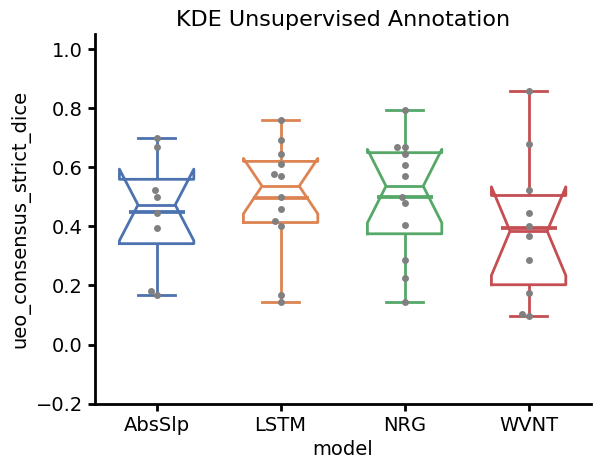

In [60]:
pt_pred_channels_wdice = pred_channels_wdice.groupby(['Patient','model'])[['ueo_consensus_strict_dice']].mean().reset_index()
bx = sns.boxplot(pt_pred_channels_wdice,x='model',y='ueo_consensus_strict_dice',palette='deep',order=['AbsSlp','LSTM','NRG','WVNT'],width=.6,notch=True,fill=False)
sns.swarmplot(pt_pred_channels_wdice,x='model',y='ueo_consensus_strict_dice',color='gray')
sns.pointplot(pt_pred_channels_wdice,x='model',y='ueo_consensus_strict_dice',palette='deep',order = ['AbsSlp','LSTM','NRG','WVNT'],marker='_',markersize=40,errorbar=None)
sns.despine()
plt.ylim([-.2,1.05])
plt.title("KDE Unsupervised Annotation")

In [55]:
all_ps = []
for i_mdl in pred_channels_wdice.model.unique():
    for j_mdl in pred_channels_wdice.model.unique():
        print(i_mdl,j_mdl)
        p = sc.stats.mannwhitneyu(pred_channels_wdice[pred_channels_wdice.model == i_mdl].ueo_consensus_strict_dice,pred_channels_wdice[pred_channels_wdice.model == j_mdl].ueo_consensus_strict_dice)
        d=cohens_d(pred_channels_wdice[pred_channels_wdice.model == i_mdl].ueo_consensus_strict_dice,
                 pred_channels_wdice[pred_channels_wdice.model == j_mdl].ueo_consensus_strict_dice)
        print(d)
        all_ps.append(p)
        print(p)

WVNT WVNT
0.0
MannwhitneyuResult(statistic=684.5, pvalue=1.0)
WVNT NRG
-0.39146135725364606
MannwhitneyuResult(statistic=559.5, pvalue=0.1451211086289338)
WVNT AbsSlp
0.12320619755388189
MannwhitneyuResult(statistic=743.0, pvalue=0.4621021155936984)
WVNT LSTM
-0.591537669589861
MannwhitneyuResult(statistic=472.5, pvalue=0.015569625339482022)
NRG WVNT
0.39146135725364606
MannwhitneyuResult(statistic=809.5, pvalue=0.1451211086289338)
NRG NRG
0.0
MannwhitneyuResult(statistic=684.5, pvalue=1.0)
NRG AbsSlp
0.5122337734656717
MannwhitneyuResult(statistic=871.0, pvalue=0.02487338878057318)
NRG LSTM
-0.1780378986530304
MannwhitneyuResult(statistic=616.5, pvalue=0.449751188490608)
AbsSlp WVNT
-0.12320619755388189
MannwhitneyuResult(statistic=626.0, pvalue=0.4621021155936984)
AbsSlp NRG
-0.5122337734656717
MannwhitneyuResult(statistic=498.0, pvalue=0.02487338878057318)
AbsSlp AbsSlp
0.0
MannwhitneyuResult(statistic=684.5, pvalue=1.0)
AbsSlp LSTM
-0.7198682146184486
MannwhitneyuResult(statistic=4

## Alternate Annotations

In [47]:
alt_annots = pd.read_csv(ospj(metapath,'Results_Raw_FINAL.csv'))

In [48]:
alt_onset_annots_1k = alt_annots[(alt_annots['Cutoff Frequency'] == 1000) & (alt_annots['Symbol Number'] == str(1))]
grouped_annots = alt_onset_annots_1k.groupby(['Marker','Patient File']).apply(lambda x: [y['Channel Marked'] for _,y in x.iterrows()]).reset_index()

In [49]:
all_dice = []
for i_g, group in grouped_annots.groupby('Patient File'):
    if len(group) <= 1:
        continue
    dice_val = 0
    for i_annot in range(len(group)):
        for j_annot in range(i_annot+1,len(group)):
            dice_val += dice_score(np.atleast_1d(group.iloc[i_annot,2]),np.atleast_1d(group.iloc[j_annot,2]))
    dice_val /= (len(group)*(len(group)-1))/2
    all_dice.append(dice_val)

MannwhitneyuResult(statistic=250.0, pvalue=0.5807794949450504) -0.22843322883041672


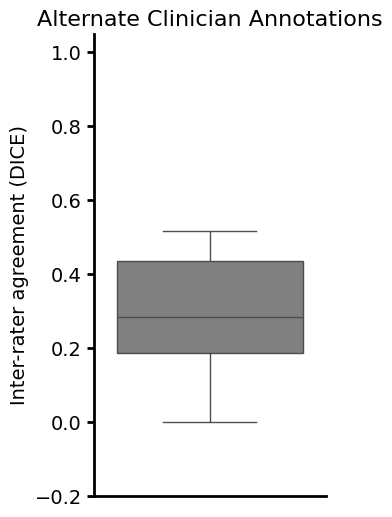

In [56]:
plt.figure(figsize=(3,6))
sns.boxplot(all_dice,color='gray')
sns.despine()
plt.title('Alternate Clinician Annotations')
plt.ylabel('Inter-rater agreement (DICE)')
plt.ylim([-.2,1.05])
plt.xticks([])

# sc.stats.mannwhitneyu(all_dice,all_plot_agreements[all_plot_agreements.model == 'LSTM'].dice),
print(sc.stats.mannwhitneyu(all_dice,pred_channels_wdice[pred_channels_wdice.model == 'LSTM'].ueo_consensus_strict_dice),
cohens_d(all_dice,pred_channels_wdice[pred_channels_wdice.model == 'LSTM'].ueo_consensus_strict_dice))